### Predicting transfer value of football players using ML (statistics and additional attributes)

In [14]:
# Importing relevant libaries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup, NavigableString, Tag
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [8]:
#Specify relevant seasons and leagues
years = ['2017-2018','2018-2019','2019-2020','2020-2021','2021-2022']
leagues = ['spanish-la-liga','italian-serie-a','german-bundesliga','english-premier-league','rest-of-europe']
stats = ['stats_standard','stats_passing','stats_defense']
stats_to_keep = ['Player','Nation','Pos','Squad','Age','MP','Starts','Min','90s','Gls','Ast','G-PK','CrdY','CrdR','Cmp%','KP','1/3','PPA','CrsPA',
'Prog','Tkl','TklW','Int','Err','Blocks','Tkl%','Year']

#Test list
years_test = ['2017-2018','2018-2019']
leagues_test = ['english-premier-league']
stats_test = ['stats_passing']

In [3]:
def scrape_stats(driver,id,id_):
    '''
    Function to scrape football stats from fbref

    Args: 
    driver (html code): 
    id (string): Defines the table of content based on developer tool
    id_ (string): Defines which type of stats to scrape for 

    Returns:
    columns (list): Relevant columns  
    data (list): Relevant data
    '''

    # 1. Set up beautifulsoup function in order to scrape the specified driver
    soup = BeautifulSoup(driver.page_source, 'lxml')
    table_node = soup.find(id=id) # Defines the tabel of content based on id 

    # 2. Extract columns based on 'th' and save in new list 'columns'
    columns_html = table_node.thead.find_all('th')
        # Extract the text
    columns = []
    for col in columns_html:
        columns.append(col.text)

    # 3. Due to an extra unnecessary column when scraping stats for passing and defensive a if loop is performed
    if id_ == 'standard':
        columns = columns[7:]
    else:
        columns = columns[8:]

    # 4. Extract each row based on 'tr' and iterate through storing child for each row node in list 'data'
    rows_list = table_node.tbody.find_all('tr')
    data = []
    for row_node in rows_list:
        try:
            row = []
            for child in row_node.children:
                row.append(child.text)
            data.append(row)
        except:
            pass
    
    # 5. Return relevant information
    return columns, data


def clean_statistics(columns,data,period):
    '''
    Function to clean football stats
    
    Args:
    columns (list): takes the columns defined by the function 'scrape_stats' as input in order to specify columns in dataframe
    data (list): takes the columns defined by the function 'scrape_stats' as input in order to specify values in dataframe
    period (list): creates a indicator variable in order to merge later on

    Returns:
    df_out (dataframe): Returns a clean dataframe containing all data
    '''

    # 1. Using one chain method in order to clean dataframe
    df_out = pd.DataFrame(data,columns=columns)\
        .iloc[:,:-1]\
        .assign(Nation= lambda x: x['Nation'].str.split(' ').str[1], 
            Pos = lambda x: x['Pos'].str.split(',').str[0], 
            Comp = lambda x: x['Comp'].str.split(None,1).str[1],
            # Pos = lambda x: pd.Categorical(x['Pos']),
            Squad = lambda x: pd.Categorical(x['Squad']),
            Year = period[0:4])
            # Nation = lambda x: pd.Categorical(x['Nation']))

    # 2. Return clean dataframe
    return df_out

In [4]:
def get_stats(periods,stats):
    '''
    Function to combine the two functions 'scrape_stats' and 'clean_statistics

    Args:
    periods (list): Specify the choosen period for which data will be scraped
    stats (list): Specify which stats are of interest

    Returns:
    dict (dictionary): Returns a dictionary containing dataframe for each type of stats selected by the input 'stats'
    
    '''


    # 1. Creates an empty dictionary
    dict = {}

    # 2. Iterate trough each type of stats
    for id in stats:
        id = id # Set id equal to id choosen in loop
        id_ = id.split('_')[-1] # Temp id variable which takes on substrin after delimiter in order to change urls
        df_stats_ = [] # Create empty list for storing dataframes

        # a. Itereate trough each period 
        for period in periods:
            time.sleep(5) # Sleep due to request from fbref to impose a pause of at least 3 seconds between each call
            if id.split('_')[-1] == 'standard':
                url = f'https://fbref.com/en/comps/Big5/{period}/stats/players/{period}-Big-5-European-Leagues-Stats'
            else:
                url = f'https://fbref.com/en/comps/Big5/{period}/{id_}/players/{period}-Big-5-European-Leagues-Stats'
            driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
            driver.get(url)
            time.sleep(3)
            cookie = driver.find_element(By.CLASS_NAME,'qc-cmp2-summary-buttons').click()

            # i. Call function 'scrape_stats' in order to retreive list containing columns and data
            columns, data = scrape_stats(driver,id,id_)

            # ii. Append clean dataframe to list 'df_stats_' by calling the function 'clean_statistics'
            df_stats_.append(clean_statistics(columns, data, period))

        # b. Create dataframe for each type of stat containning statistics for all periods and store in dictionary with key equal to type of stats denoted by 'id'
        df_concat = pd.concat(df_stats_)
        dict[id] = df_concat

    # 3. Return relevant dictionary
    return dict


In [17]:
stats_dict = get_stats(years_test,stats)

<ipython-input-16-10da1e3cc0dd>:16: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver


In [5]:
def merge_stats(dict):
    '''
    Function in order to combine a dataframe containing desired statistics for each observation
    '''

    # 1. Create an empty dataframe
    main_df = pd.DataFrame()

    # 2. Unpack dictionary containing data for each type of stats
    keys, values = [list(x) for x in zip(*dict.items())]
    for key in keys:
        df_ = values[keys.index(key)]\
            .assign(Year = lambda x: pd.to_datetime(x['Year'],format='%Y'))

        # a. Combine statistics for each player based on a simple merge function on 'Player', 'Year' and 'Squad'
        if main_df.empty:
            main_df = df_
        else:
            main_df = main_df.merge(df_, how='left', on=['Player','Year','Squad'])

    # 3. Clean column by removing duplicates denoted by _y
    main_df.drop(main_df.columns[main_df.columns.str.contains('_y')], axis=1, inplace=True)

    # 4. Rename instances where _x appears back to the original  
    col_list = list(main_df.columns)
    col_list_ = []
    for col in col_list:
        col_list_.append(col.replace('_x',''))
    main_df.columns = col_list_

    # 5. Final clean of data
    main_df = main_df.loc[:, ~main_df.columns.duplicated()]
    main_df.drop('Rk',axis=1,inplace=True)
    main_df['Year']= pd.DatetimeIndex(main_df['Year']).year
    # main_df = main_df[stats_to_keep]

    # 6. Return main dataframe
    return main_df

In [6]:
df_all_stats = merge_stats(get_stats(years,stats))


[WDM] - Downloading: 100%|██████████| 6.21M/6.21M [00:00<00:00, 13.2MB/s]
<ipython-input-4-f1eaf34bd385>:31: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver


In [19]:
df_all_stats

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,Succ,%,Blocks,Sh,ShSv,Pass,Int,Tkl+Int,Clr,Err
0,Patrick van Aanholt,NED,DF,Crystal Palace,Premier League,26,1990,28,25,"2,184",...,92,34.8,35,5,0,30,45,100,69,2
1,Rolando Aarons,ENG,MF,Hellas Verona,Serie A,21,1995,11,6,517,...,32,27.4,4,0,0,4,1,13,0,0
2,Rolando Aarons,ENG,FW,Newcastle Utd,Premier League,21,1995,4,1,139,...,9,23.1,3,0,0,3,2,7,0,0
3,Ignazio Abate,ITA,DF,Milan,Serie A,30,1986,17,11,"1,057",...,46,32.6,29,2,0,27,4,25,17,0
4,Aymen Abdennour,TUN,DF,Marseille,Ligue 1,27,1989,8,6,499,...,8,34.8,6,3,0,3,2,8,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13817,Kurt Zouma,FRA,DF,West Ham,Premier League,26,1994,24,24,"2,078",...,35,32.7,38,27,0,11,47,58,140,0
13818,Petar Zovko,BIH,GK,Spezia,Serie A,19,2002,1,0,29,...,0,,0,0,0,0,0,0,0,0
13819,Igor Zubeldia,ESP,DF,Real Sociedad,La Liga,24,1997,26,19,"1,648",...,48,31.0,27,9,0,18,31,57,63,0
13820,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,22,1999,36,26,"2,591",...,129,32.7,39,14,0,25,50,111,64,0


In [22]:
# df_all_stats = df_all_stats[stats_to_keep]
df_all_stats.head(10)
df_all_stats.to_csv('Full_stats_df.csv')


In [ ]:
df_list = []
id = 'stats_passing'
url = 'https://fbref.com/en/comps/Big5/2018-2019/passing/players/2018-2019-Big-5-European-Leagues-Stats'
driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
driver.get(url)
time.sleep(3)
cookie = driver.find_element(By.CLASS_NAME,'qc-cmp2-summary-buttons').click()

soup = BeautifulSoup(driver.page_source, 'lxml')
table_node = soup.find(id=id)

columns_html = table_node.thead.find_all('th')
    # Extract the text
columns = []
for col in columns_html:
    columns.append(col.text)
# columns = columns[8:]
print(len(columns))
rows_list = table_node.tbody.find_all('tr')

data = []
for row_node in rows_list:
    # if (rows_list.index(row_node) % 25 == 0):
    try:
        row = []
        for child in row_node.children:
            row.append(child.text)
        data.append(row)
    except:
        pass

# df_list.append(clean_statistics(columns, data, years_test))

df_out = pd.DataFrame(data,columns=columns)\
    .iloc[:,:-1]\
    .assign(Nation= lambda x: x['Nation'].str.split(' ').str[1],
        Pos = lambda x: x['Pos'].str.split(',').str[0], 
        Comp = lambda x: x['Comp'].str.split(None,1).str[1],
        # Pos = lambda x: pd.Categorical(x['Pos']),
        Squad = lambda x: pd.Categorical(x['Squad']))
        # Year = period[0:4])
# time.sleep(10)

# main_df = pd.concat(df_list)
# print(f'Number of observations in main dataset is: {len(main_df)}')
# return main_df




In [ ]:
test = get_standard_stats(years_test,stats_test)

In [5]:
df_stats['Year']= pd.to_datetime(df_stats['Year'], format='%Y')
df_stats['Year']= pd.DatetimeIndex(df_stats['Year']).year


In [8]:
def scrape_transferprice(driver,id):
    soup = BeautifulSoup(driver.page_source, 'lxml')
    table_node = soup.find(id=id)

    columns_html = table_node.thead.find_all('th')
        # Extract the text
    transfer_columns = []
    for col in columns_html:
        transfer_columns.append(col.text)

    rows_list = table_node.tbody.find_all('tr')

    transfer_data = []
    for row_node in rows_list:
        row = []
        for child in row_node.children:
            try:
                row.append(child.text)
            except:
                pass
        transfer_data.append(row)
    
    return transfer_columns, transfer_data

def clean_transfer(columns,data,period):    
    transfer_df = pd.DataFrame(data, columns=columns)\
                .assign(When = lambda x: x['When'].str.split(' ').str[0],
                    Price = lambda x: x['Price'].str.split('(?:(.*\d))?(?:([a-zA-Z]+))?').str[1],
                    Player = lambda x: x['Player'].str.rsplit(' ').str[:-1].apply(' '.join),
                    Price_ = lambda x: x['Price'].str.replace(',','').astype(float),
                    Price_m = lambda x: (x['Price_'] > 500) * x['Price_'] * 1/1000000 + (x['Price_'] <= 500) * x['Price_'],
                    Year = int(period[0:4])-1)\
                .query("When != 'Jan'")\
                .replace(to_replace='None', value=np.nan).dropna()

    transfer_df.drop(transfer_df.columns[[0,1,4,6,7]],axis=1, inplace=True)
    # new_df['Price (m)'] = new_df['Price'].str.replace(',','').astype(float)
    # new_df['Price (m)'] = (new_df['Price (m)'] > 500) * new_df['Price (m)'] * 1/1000000 + (new_df['Price (m)'] <= 500) * new_df['Price (m)']

    return transfer_df                         

In [9]:
def get_transferprice(leagues,years):
    id = 'feed-tabs'
    df_transferprice = []
    for league in leagues:

        df_transferprice_ = []
        
        for periods in years:
            url = f'https://www.soccernews.com/soccer-transfers/{league}-transfers-{periods}/'
            driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
            driver.get(url)
            # time.sleep(3)
            # cookie = driver.find_element(By.ID,'cn-accept-cookie').click()
            
            # Get data
            columns_transfer, transfer_data = scrape_transferprice(driver,id)

            df_transferprice_.append(clean_transfer(columns_transfer,transfer_data,periods))
    
        df_transferprice.append(pd.concat(df_transferprice_))

    return pd.concat(df_transferprice)
#     main_transfer = pd.concat(df_transferprice)
#     print(f'Number of observations in main dataset is: {len(main_transfer)}')

#     return main_transfer

# main_transfer_df = get_transferprice(leagues_test,years)

In [12]:
df_transferprice = get_transferprice(leagues,years)

<ipython-input-9-368aca447d41>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-9-368aca447d41>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-9-368aca447d41>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-9-368aca447d41>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-9-368aca447d41>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-9-368aca447d41>:10: 

In [21]:
df_transferprice.to_csv('Full_transfer_df.csv')

In [25]:
df_transferprice.to_csv('Transfer.csv')

In [135]:
df_transferprice['Year']= pd.to_datetime(df_transferprice['Year'], format='%Y')
df_transferprice['Year']= pd.DatetimeIndex(df_transferprice['Year']).year
df_transferprice.tail(10)

,Player,From,To,Price,Year
126,Jonathan Panzo,Chelsea,Monaco,2.8,2017
128,Pele,Rio Ave,Monaco,9,2017
130,Yuto Nagatomo,Inter Milan,Galatasaray,2.25,2017
132,Dusan Tadic,Southampton,Ajax,11.3,2017
133,Emiliano Viviano,Sampdoria,Sporting CP,1.8,2017
135,Willem Geubbels,Olympique Lyon,AS Monaco,18,2017
137,Saidy Janko,St. Etienne,FC Porto,2.7,2017
138,Angelino,Manchester City,PSV Eindhoven,5.7,2017
140,Danilo,Braga,Nice,8,2017
142,Samuel Grandsir,Troyes,AS Monaco,2.7,2017


### Trying to merge transfer data with statistics

### **Hvis du har mod på det må du meget gerne kigge på dette, Carl Philip**

De to datasæt skal merges så vi ender med et samlet datasæt med stats og transferpris

In [16]:
#new_df = test_stats_merge.merge(test_transfer_merge, how='left', left_on=['Player','Year'], right_on=['Price'])

new_df = df_all_stats.merge(df_transferprice, how='left', on=['Player','Year'])
new_df.dropna(subset=['Price_m'],inplace=True)

# Nu skal der bare droppes de rows med NaN i price

In [20]:
new_df.to_csv('Main_df_til_leg.csv')

In [48]:
new_df.to_csv('til Carl Philip.csv')

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,npxG+xA,xG,xA,xG+xA,npxG,npxG+xA,Year,From,To,Price
0,779,Fabinho,BRA,MF,Monaco,Ligue 1,23,1993,34,34,...,6.2,0.16,0.11,0.27,0.07,0.18,2017,AS Monaco,Liverpool,45
1,766,Fabinho,BRA,MF,Liverpool,Premier League,24,1993,28,21,...,2.1,0.04,0.06,0.09,0.04,0.09,2018,NaN,NaN,NaN


### Celle til leg med plots (Carl Philip)

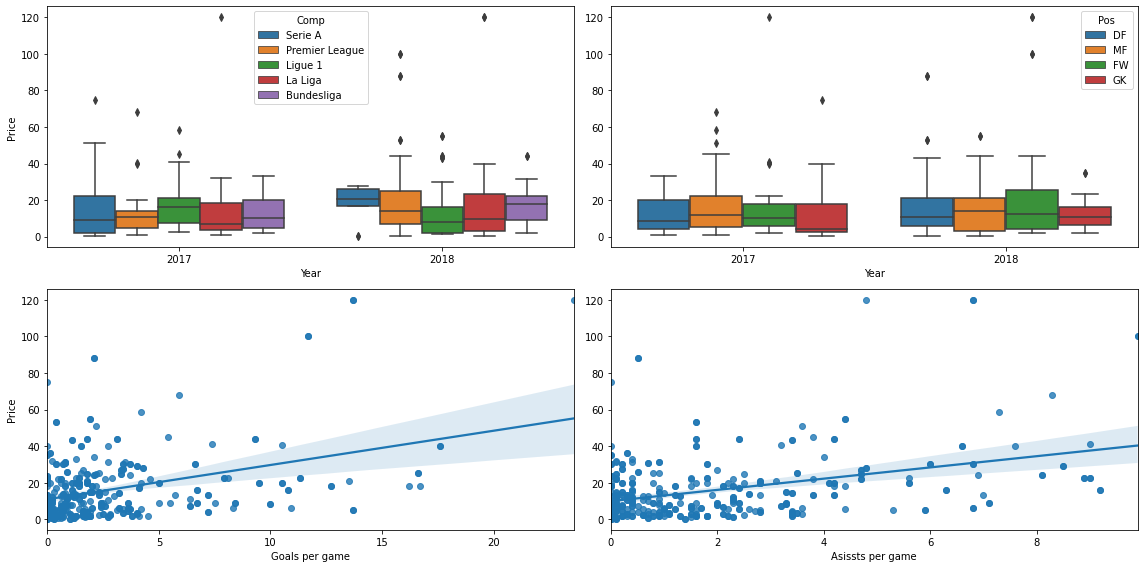

In [2]:
# Import graphical packages
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# sns.set_theme(style="white")

# Data cleaning for copy paste
new_df=pd.read_csv(Path.cwd() / 'til Carl Philip.csv')
new_df['Price (m)'] = new_df['Price'].str.replace(',','').astype(float)
new_df['Price (m)'] = (new_df['Price (m)'] > 500) * new_df['Price (m)'] * 1/1000000 + (new_df['Price (m)'] <= 500) * new_df['Price (m)']

# Define plot
f,ax = plt.subplots(2,2, figsize=(16,8))

# First row
sns.boxplot(x='Year', y='Price (m)', data=new_df, hue="Comp", ax=ax[0, 0]).set( xlabel = "Year", ylabel = "Price")
sns.boxplot(x='Year', y='Price (m)', data=new_df, hue="Pos", ax=ax[0, 1]).set( xlabel = "Year", ylabel = "")

# Second row
sns.regplot(x='xG', y='Price (m)', data=new_df, ax=ax[1, 0]).set( xlabel = "Goals per game", ylabel = "Price")
sns.regplot(x='xA', y='Price (m)', data=new_df, ax=ax[1, 1]).set( xlabel = "Asissts per game", ylabel = "")
f.tight_layout()

# Create path to save figure
fp_figs = Path.cwd() / 'figs'  
# Use the Path object to actually create the subfolder
Path.mkdir(fp_figs, exist_ok=True)  
# Export for paper
plt.savefig('figs/pic1.png')




In [20]:
new_df.to_csv('sdgsgs.csv')

# **Celle til Oliver**

In [53]:
modeldata=pd.read_csv('Main_df_til_leg.csv')
modeldata_v2=pd.read_csv('Main_df_til_leg.csv')
# Define all variables needed in analysis
all_variables = ['Pos','Age','Ast','G-PK','CrdY','CrdR','Cmp%','PPA','1/3',
'Int','Tkl%', 'Price_m']
# Filter so only variables need in analysis included
modeldata = modeldata[all_variables]

# Delete GK
modeldata = modeldata[modeldata.Pos != 'GK']

# Convert position to dummy
positioncolumn = ['Pos']
modeldata= pd.get_dummies(modeldata, columns=positioncolumn,drop_first=True)

# Convert minutes to float
# modeldata['Min'] = modeldata['Min'].str.replace(',','')

# FIll nan with zeroes (nan only present when the playes has had in fact zero)
modeldata = modeldata.fillna(0)

# Convert to float
modeldata = modeldata.astype(float)

# # Define y and x
y = np.log(modeldata['Price_m'])
X = modeldata.loc[:, modeldata.columns != 'Price_m']

olsmod = sm.OLS(y, X)
X = sm.add_constant(X)
olsres = olsmod.fit()
print(olsres.summary())



                                 OLS Regression Results                                
Dep. Variable:                Price_m   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                              221.2
Date:                Tue, 16 Aug 2022   Prob (F-statistic):                   1.34e-163
Time:                        13:25:33   Log-Likelihood:                         -508.67
No. Observations:                 394   AIC:                                      1041.
Df Residuals:                     382   BIC:                                      1089.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<AxesSubplot:>

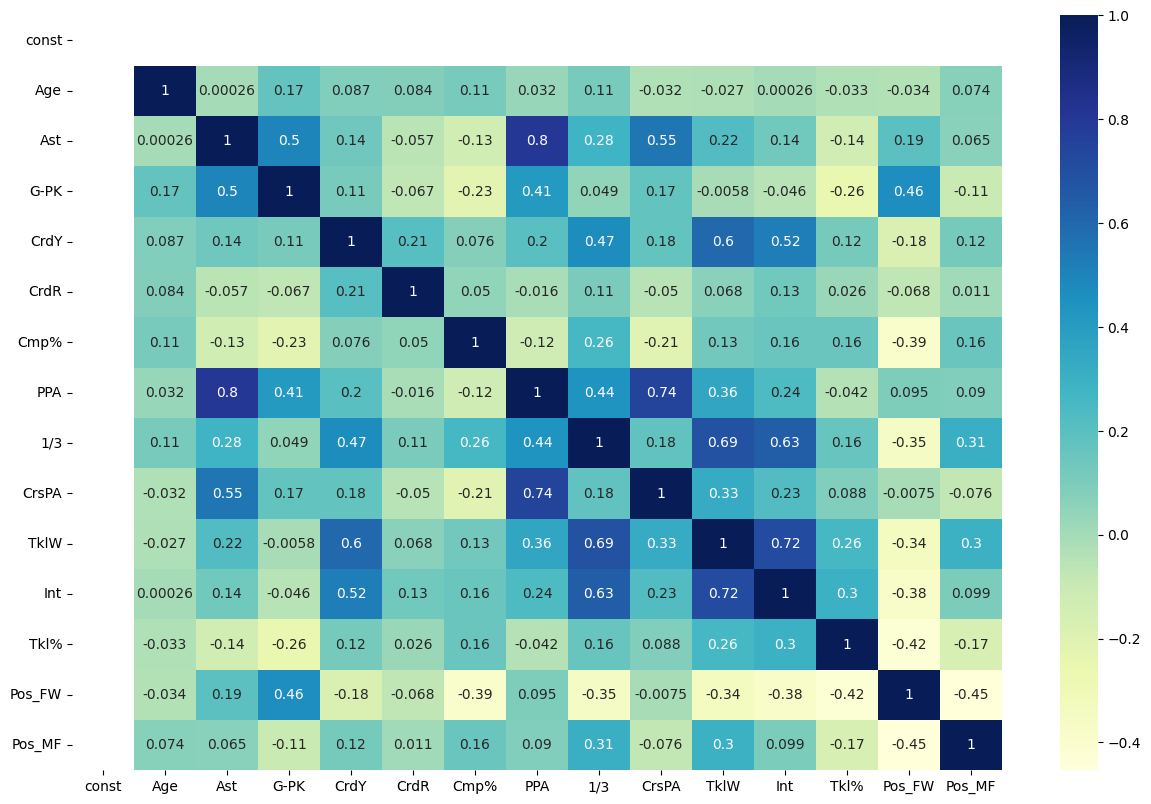

In [51]:
from matplotlib.pyplot import figure
corr_matrix = X.corr()
corr_matrix

figure(figsize=(15,10), dpi=100)
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')



Pos
DF    148
FW    118
GK     34
MF    128
dtype: int64


<AxesSubplot:xlabel='Pos'>

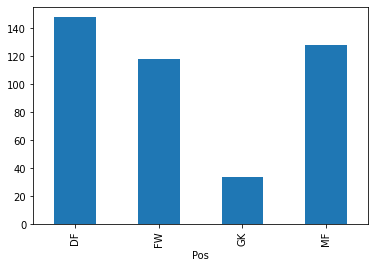

In [38]:
GroupedData=modeldata_v2.groupby(by='Pos').size()
print(GroupedData)
 
# Generating a bar chart for a single column
%matplotlib inline
GroupedData.plot.bar()

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output = []

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)    
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=random_state)

    reg = LinearRegression().fit(X_train, y_train)
    reg.predict(X_test)

    output.append([rmse(reg.predict(X_val), y_val),
                   rmse(reg.predict(X_test), y_test)])
    
pd.DataFrame(output, columns=['test', 'validation']).describe()

,test,validation
count,10.000000,10.000000
mean,0.899421,0.875022
std,0.065388,0.049460
min,0.774722,0.792900
25%,0.849207,0.831982
50%,0.914113,0.890810
75%,0.951011,0.907180
max,0.969921,0.943626


# **Celle til Mathias** 

# **Celle til Carl Philip**

In [48]:
import sklearn
from sklearn.linear_model import LinearRegression


modeldata=pd.read_csv(Path.cwd() / 'Main_df_til_leg.csv')

# Define all variables needed in analysis
all_variables = ['Pos','Age','MP','Starts','Min','90s','Gls','Ast','G-PK','CrdY','CrdR','Cmp%','KP','1/3','PPA','CrsPA',
'Prog','Tkl','TklW','Int','Err','Blocks','Tkl%','Year', 'Price_m']
# Filter so only variables need in analysis included
modeldata = modeldata[all_variables]

# Delete GK
modeldata = modeldata[modeldata.Pos != 'GK']

# Convert position to dummy
positioncolumn = ['Pos']
modeldata= pd.get_dummies(modeldata, columns=positioncolumn)

# Convert minutes to float
modeldata['Min'] = modeldata['Min'].str.replace(',','')

# FIll nan with zeroes (nan only present when the playes has had in fact zero)
modeldata = modeldata.fillna(0)

# Convert to float
modeldata = modeldata.astype(float)


# Define y and x
y = modeldata['Price_m']
x = modeldata.loc[:, modeldata.columns != 'Price_m']



In [49]:
regressor = LinearRegression()  

regressor.fit(x, y)

LinearRegression()